# Загрузка данных

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

aak204_gdfag3424_path = kagglehub.dataset_download('aak204/gdfag3424')

print('Data source import complete.')


100%|██████████| 1.25G/1.25G [00:11<00:00, 114MB/s]

Extracting files...


Data source import complete.


In [ ]:
print("Installing/Updating libraries...")
!pip install --upgrade torchaudio python-Levenshtein -q
print("Installation finished.")

Installing/Updating libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 102.6 MB/s eta 0:00:00
Installa

In [ ]:
aak204_gdfag3424_path

'/root/.cache/kagglehub/datasets/aak204/gdfag3424/versions/1'

In [ ]:
import shutil, os

In [ ]:
SRC = "/root/.cache/kagglehub/datasets/aak204/gdfag3424/versions/1"
DST = "/content/gdfag3424"
if not os.path.exists(DST):
    shutil.copytree(SRC, DST)
print("✅ dataset copied to /content/gdfag3424")

✅ dataset copied to /content/gdfag3424


In [ ]:
import os
import time
import random
import re
import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
import torchaudio.transforms as T

try:
    import Levenshtein
except ImportError:
    try:
        import google.colab
        print("Installing Levenshtein for Kaggle/Colab...")
        import subprocess; import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "python-Levenshtein", "-q"])
    except ImportError:
        print("Levenshtein not found. Installing locally...")
        import subprocess; import sys
        try: subprocess.check_call([sys.executable, "-m", "pip", "install", "python-Levenshtein"])
        except Exception as e: print(f"Failed to install Levenshtein: {e}"); exit()
    import Levenshtein
    print("Levenshtein ready.")

try:
    from tqdm.notebook import tqdm
    print("Using tqdm.notebook")
except ImportError:
    from tqdm import tqdm
    print("Using standard tqdm")

from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split

# EDA

Loading train CSV...
Loaded 30000 records from /content/gdfag3424/train.csv
Duration cache not found. Calculating all durations...
Calculating durations for 30000 training files...


Calculating durations:   0%|          | 0/30000 [00:00<?, ?it/s]

Saving calculated durations to /content/train_audio_durations.csv...

--- Train Set Duration Analysis ---

Descriptive Statistics for Valid Durations (ms):
count    30000.0
mean      8000.0
std          0.0
min       8000.0
1%        8000.0
5%        8000.0
25%       8000.0
50%       8000.0
75%       8000.0
95%       8000.0
99%       8000.0
max       8000.0
dtype: float64

Duration distribution plot saved to /content/train_duration_distribution.png


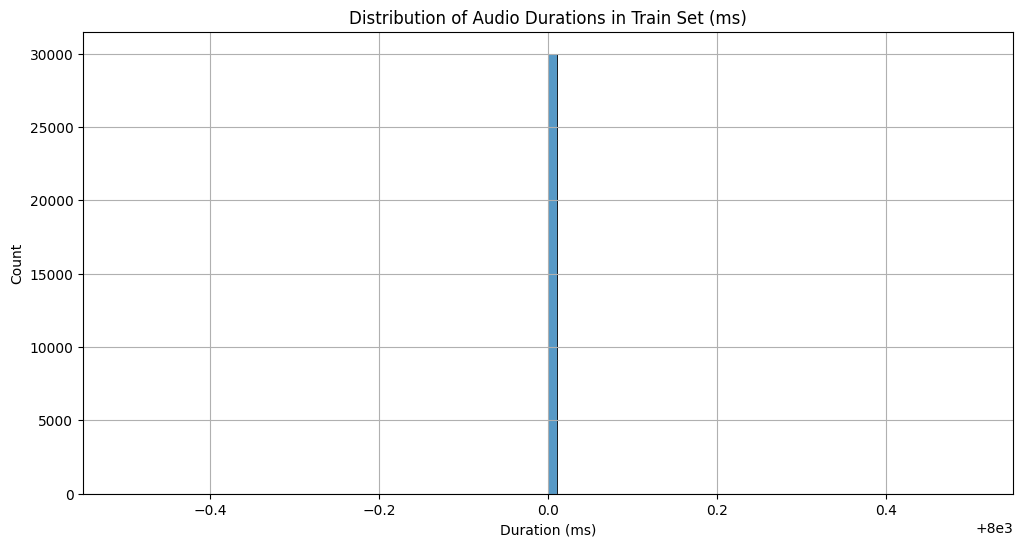


--- Analysis Complete ---


In [ ]:
KAGGLE_INPUT_DIR = '/content/gdfag3424'
KAGGLE_WORKING_DIR = "/content/"

AUDIO_DIR_RELATIVE = os.path.join('morse_dataset', 'morse_dataset')
AUDIO_DIR = os.path.join(DATA_DIR, AUDIO_DIR_RELATIVE)
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Параметры ---
TARGET_SAMPLE_RATE = 8000 # Целевая частота дискретизации
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Вспомогательная функция для получения длительности ---
def get_audio_duration_ms(file_path, target_sr=TARGET_SAMPLE_RATE):
    """
    Получает длительность аудиофайла в миллисекундах, используя torchaudio.info.
    Учитывает разницу в sample rate.
    """
    try:
        info = torchaudio.info(file_path)
        source_sr = info.sample_rate
        num_frames = info.num_frames

        # Рассчитываем длительность в секундах на исходной частоте
        duration_sec = num_frames / source_sr

        # Переводим в миллисекунды
        duration_ms = int(duration_sec * 1000)
        return duration_ms

    except FileNotFoundError:
        print(f"Warning: File not found: {file_path}")
        return 0 # Возвращаем 0 при ошибке
    except Exception as e:
        print(f"Warning: Error getting info for {file_path}: {type(e).__name__} - {e}")
        return 0 # Возвращаем 0 при ошибке

# --- Основной блок анализа ---

print("Loading train CSV...")
try:
    train_df = pd.read_csv(TRAIN_CSV)
    print(f"Loaded {len(train_df)} records from {TRAIN_CSV}")
except FileNotFoundError as e:
    print(f"Error loading CSV: {e}"); exit()

# --- Расчет длительностей (с кэшированием) ---
duration_cache_path = os.path.join(OUTPUT_DIR, "train_audio_durations.csv")
all_durations = []

if os.path.exists(duration_cache_path):
    print(f"Loading cached durations from {duration_cache_path}...")
    duration_df = pd.read_csv(duration_cache_path)
    # Проверим, все ли ID из train_df есть в кэше
    if set(train_df['id']) == set(duration_df['id']):
        print("Cache is complete. Using cached durations.")
        all_durations = duration_df['duration_ms'].tolist()
    else:
        print("Cache is incomplete. Recalculating all durations...")
        recalculate = True
else:
    print("Duration cache not found. Calculating all durations...")
    recalculate = True

if recalculate or not all_durations:
    all_durations_data = []
    print(f"Calculating durations for {len(train_df)} training files...")
    for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Calculating durations"):
        file_id = row['id']
        file_path = os.path.join(AUDIO_DIR, file_id)
        duration_ms = get_audio_duration_ms(file_path, TARGET_SAMPLE_RATE)
        all_durations_data.append({'id': file_id, 'duration_ms': duration_ms})

    duration_df = pd.DataFrame(all_durations_data)
    print(f"Saving calculated durations to {duration_cache_path}...")
    duration_df.to_csv(duration_cache_path, index=False)
    all_durations = duration_df['duration_ms'].tolist()

# --- Анализ и Визуализация Длительностей ---
print("\n--- Train Set Duration Analysis ---")

# Убираем нулевые длины (ошибки загрузки) перед анализом
valid_durations = [d for d in all_durations if d > 0]
num_errors = len(all_durations) - len(valid_durations)
if num_errors > 0:
    print(f"Warning: Excluded {num_errors} files with loading errors (duration 0).")

if not valid_durations:
    print("Error: No valid durations found to analyze.")
else:
    duration_series = pd.Series(valid_durations)

    # 1. Описательные статистики
    print("\nDescriptive Statistics for Valid Durations (ms):")
    print(duration_series.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).round(2))

    # 2. Визуализация распределения
    plt.figure(figsize=(12, 6))
    sns.histplot(duration_series, bins=100, kde=False) # KDE может быть медленным для большого N
    plt.title('Distribution of Audio Durations in Train Set (ms)')
    plt.xlabel('Duration (ms)')
    plt.ylabel('Count')
    plt.grid(True)

    # Добавим логарифмическую шкалу для оси X, если разброс большой
    if duration_series.max() / duration_series.min() > 50: # Эвристика
         plt.xscale('log')
         plt.title('Distribution of Audio Durations in Train Set (ms) - Log Scale')
         print("\nNote: X-axis is log-scaled due to large range.")


    duration_plot_path = os.path.join(OUTPUT_DIR, "train_duration_distribution.png")
    plt.savefig(duration_plot_path)
    print(f"\nDuration distribution plot saved to {duration_plot_path}")
    plt.show()
    plt.close()

print("\n--- Analysis Complete ---")

Loading test CSV...
Loaded 5000 records from /content/gdfag3424/test.csv
Test duration cache not found. Calculating all test durations...
Calculating durations for 5000 test files...


Calculating test durations:   0%|          | 0/5000 [00:00<?, ?it/s]

Saving calculated test durations to /content/test_audio_durations.csv...

--- Test Set Duration Analysis ---

Descriptive Statistics for Valid Test Durations (ms):
count     5000.00
mean      8136.00
std       2328.65
min       8000.00
1%        8000.00
5%        8000.00
25%       8000.00
50%       8000.00
75%       8000.00
95%       8000.00
99%       8000.00
max      48000.00
dtype: float64

Test duration distribution plot saved to /content/test_duration_distribution.png


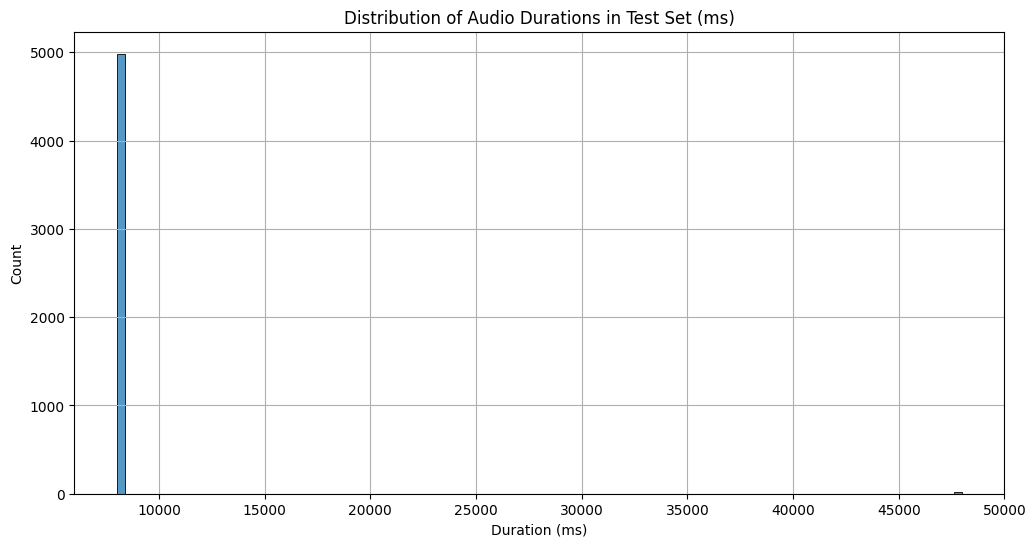


--- Test Analysis Complete ---


In [ ]:
KAGGLE_INPUT_DIR = '/content/gdfag3424'
KAGGLE_WORKING_DIR = "/content/"

IS_KAGGLE = os.path.exists(KAGGLE_INPUT_DIR)

if IS_KAGGLE:
    DATA_DIR = KAGGLE_INPUT_DIR
    OUTPUT_DIR = KAGGLE_WORKING_DIR
else:
    BASE_PROJECT_DIR = r'.'
    DATA_DIR = os.path.join(BASE_PROJECT_DIR, 'kaggle_data')
    OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'output_analysis')
    if not os.path.exists(DATA_DIR): print(f"Error: Local data directory not found at {DATA_DIR}"); exit()

AUDIO_DIR_RELATIVE = os.path.join('morse_dataset', 'morse_dataset')
AUDIO_DIR = os.path.join(DATA_DIR, AUDIO_DIR_RELATIVE)
TEST_CSV = os.path.join(DATA_DIR, "test.csv") # Нужен только test.csv

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Параметры ---
TARGET_SAMPLE_RATE = 8000
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Вспомогательная функция для получения длительности (та же самая) ---
def get_audio_duration_ms(file_path, target_sr=TARGET_SAMPLE_RATE):
    try:
        info = torchaudio.info(file_path)
        source_sr = info.sample_rate
        num_frames = info.num_frames
        duration_sec = num_frames / source_sr
        duration_ms = int(duration_sec * 1000)
        return duration_ms
    except FileNotFoundError:
        # print(f"Warning: File not found: {file_path}") # Раскомментировать для отладки
        return 0
    except Exception as e:
        # print(f"Warning: Error getting info for {file_path}: {type(e).__name__} - {e}") # Раскомментировать для отладки
        return 0

# --- Основной блок анализа ---

print("Loading test CSV...")
try:
    test_df = pd.read_csv(TEST_CSV)
    print(f"Loaded {len(test_df)} records from {TEST_CSV}")
except FileNotFoundError as e:
    print(f"Error loading CSV: {e}"); exit()

# --- Расчет длительностей для теста (с кэшированием) ---
duration_cache_path_test = os.path.join(OUTPUT_DIR, "test_audio_durations.csv")
all_durations_test = []

if os.path.exists(duration_cache_path_test):
    print(f"Loading cached test durations from {duration_cache_path_test}...")
    duration_df_test = pd.read_csv(duration_cache_path_test)
    if set(test_df['id']) == set(duration_df_test['id']):
        print("Test cache is complete. Using cached durations.")
        all_durations_test = duration_df_test['duration_ms'].tolist()
    else:
        print("Test cache is incomplete. Recalculating all test durations...")
        recalculate_test = True
else:
    print("Test duration cache not found. Calculating all test durations...")
    recalculate_test = True

if recalculate_test or not all_durations_test:
    all_durations_data_test = []
    print(f"Calculating durations for {len(test_df)} test files...")
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Calculating test durations"):
        file_id = row['id']
        file_path = os.path.join(AUDIO_DIR, file_id)
        duration_ms = get_audio_duration_ms(file_path, TARGET_SAMPLE_RATE)
        all_durations_data_test.append({'id': file_id, 'duration_ms': duration_ms})

    duration_df_test = pd.DataFrame(all_durations_data_test)
    print(f"Saving calculated test durations to {duration_cache_path_test}...")
    duration_df_test.to_csv(duration_cache_path_test, index=False)
    all_durations_test = duration_df_test['duration_ms'].tolist()

# --- Анализ и Визуализация Длительностей Теста ---
print("\n--- Test Set Duration Analysis ---")

valid_durations_test = [d for d in all_durations_test if d > 0]
num_errors_test = len(all_durations_test) - len(valid_durations_test)
if num_errors_test > 0:
    print(f"Warning: Excluded {num_errors_test} test files with loading errors (duration 0).")

if not valid_durations_test:
    print("Error: No valid test durations found to analyze.")
else:
    duration_series_test = pd.Series(valid_durations_test)

    print("\nDescriptive Statistics for Valid Test Durations (ms):")
    print(duration_series_test.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).round(2))

    plt.figure(figsize=(12, 6))
    sns.histplot(duration_series_test, bins=100, kde=False)
    plt.title('Distribution of Audio Durations in Test Set (ms)')
    plt.xlabel('Duration (ms)')
    plt.ylabel('Count')
    plt.grid(True)

    if duration_series_test.max() / duration_series_test.min() > 50: # Эвристика
         plt.xscale('log')
         plt.title('Distribution of Audio Durations in Test Set (ms) - Log Scale')
         print("\nNote: X-axis is log-scaled due to large range.")

    duration_plot_path_test = os.path.join(OUTPUT_DIR, "test_duration_distribution.png")
    plt.savefig(duration_plot_path_test)
    print(f"\nTest duration distribution plot saved to {duration_plot_path_test}")
    plt.show()
    plt.close()

print("\n--- Test Analysis Complete ---")

Loading CSV files...
Noise features cache not found. Starting noise analysis...

Analyzing noise characteristics for 30000 files from train split...


Analyzing train:   0%|          | 0/30000 [00:00<?, ?it/s]


Analyzing noise characteristics for 5000 files from test split...


Analyzing test:   0%|          | 0/5000 [00:00<?, ?it/s]

Saving calculated noise features to /content/audio_noise_features_analysis.csv...

--- Noise Analysis Results ---

Descriptive Statistics (Noise Related):
       count  mean_rms  std_rms  mean_silence_lowdb  std_silence_lowdb  \
split                                                                    
test    5000     0.575    0.040                 0.0              0.013   
train  30000     0.576    0.034                 0.0              0.000   

       mean_snr_est  std_snr_est  mean_spec_flat  std_spec_flat  
split                                                            
test          6.650        4.807           0.009          0.008  
train         6.665        4.790           0.009          0.008  

Noise feature distribution plots saved to /content/noise_feature_distributions.png


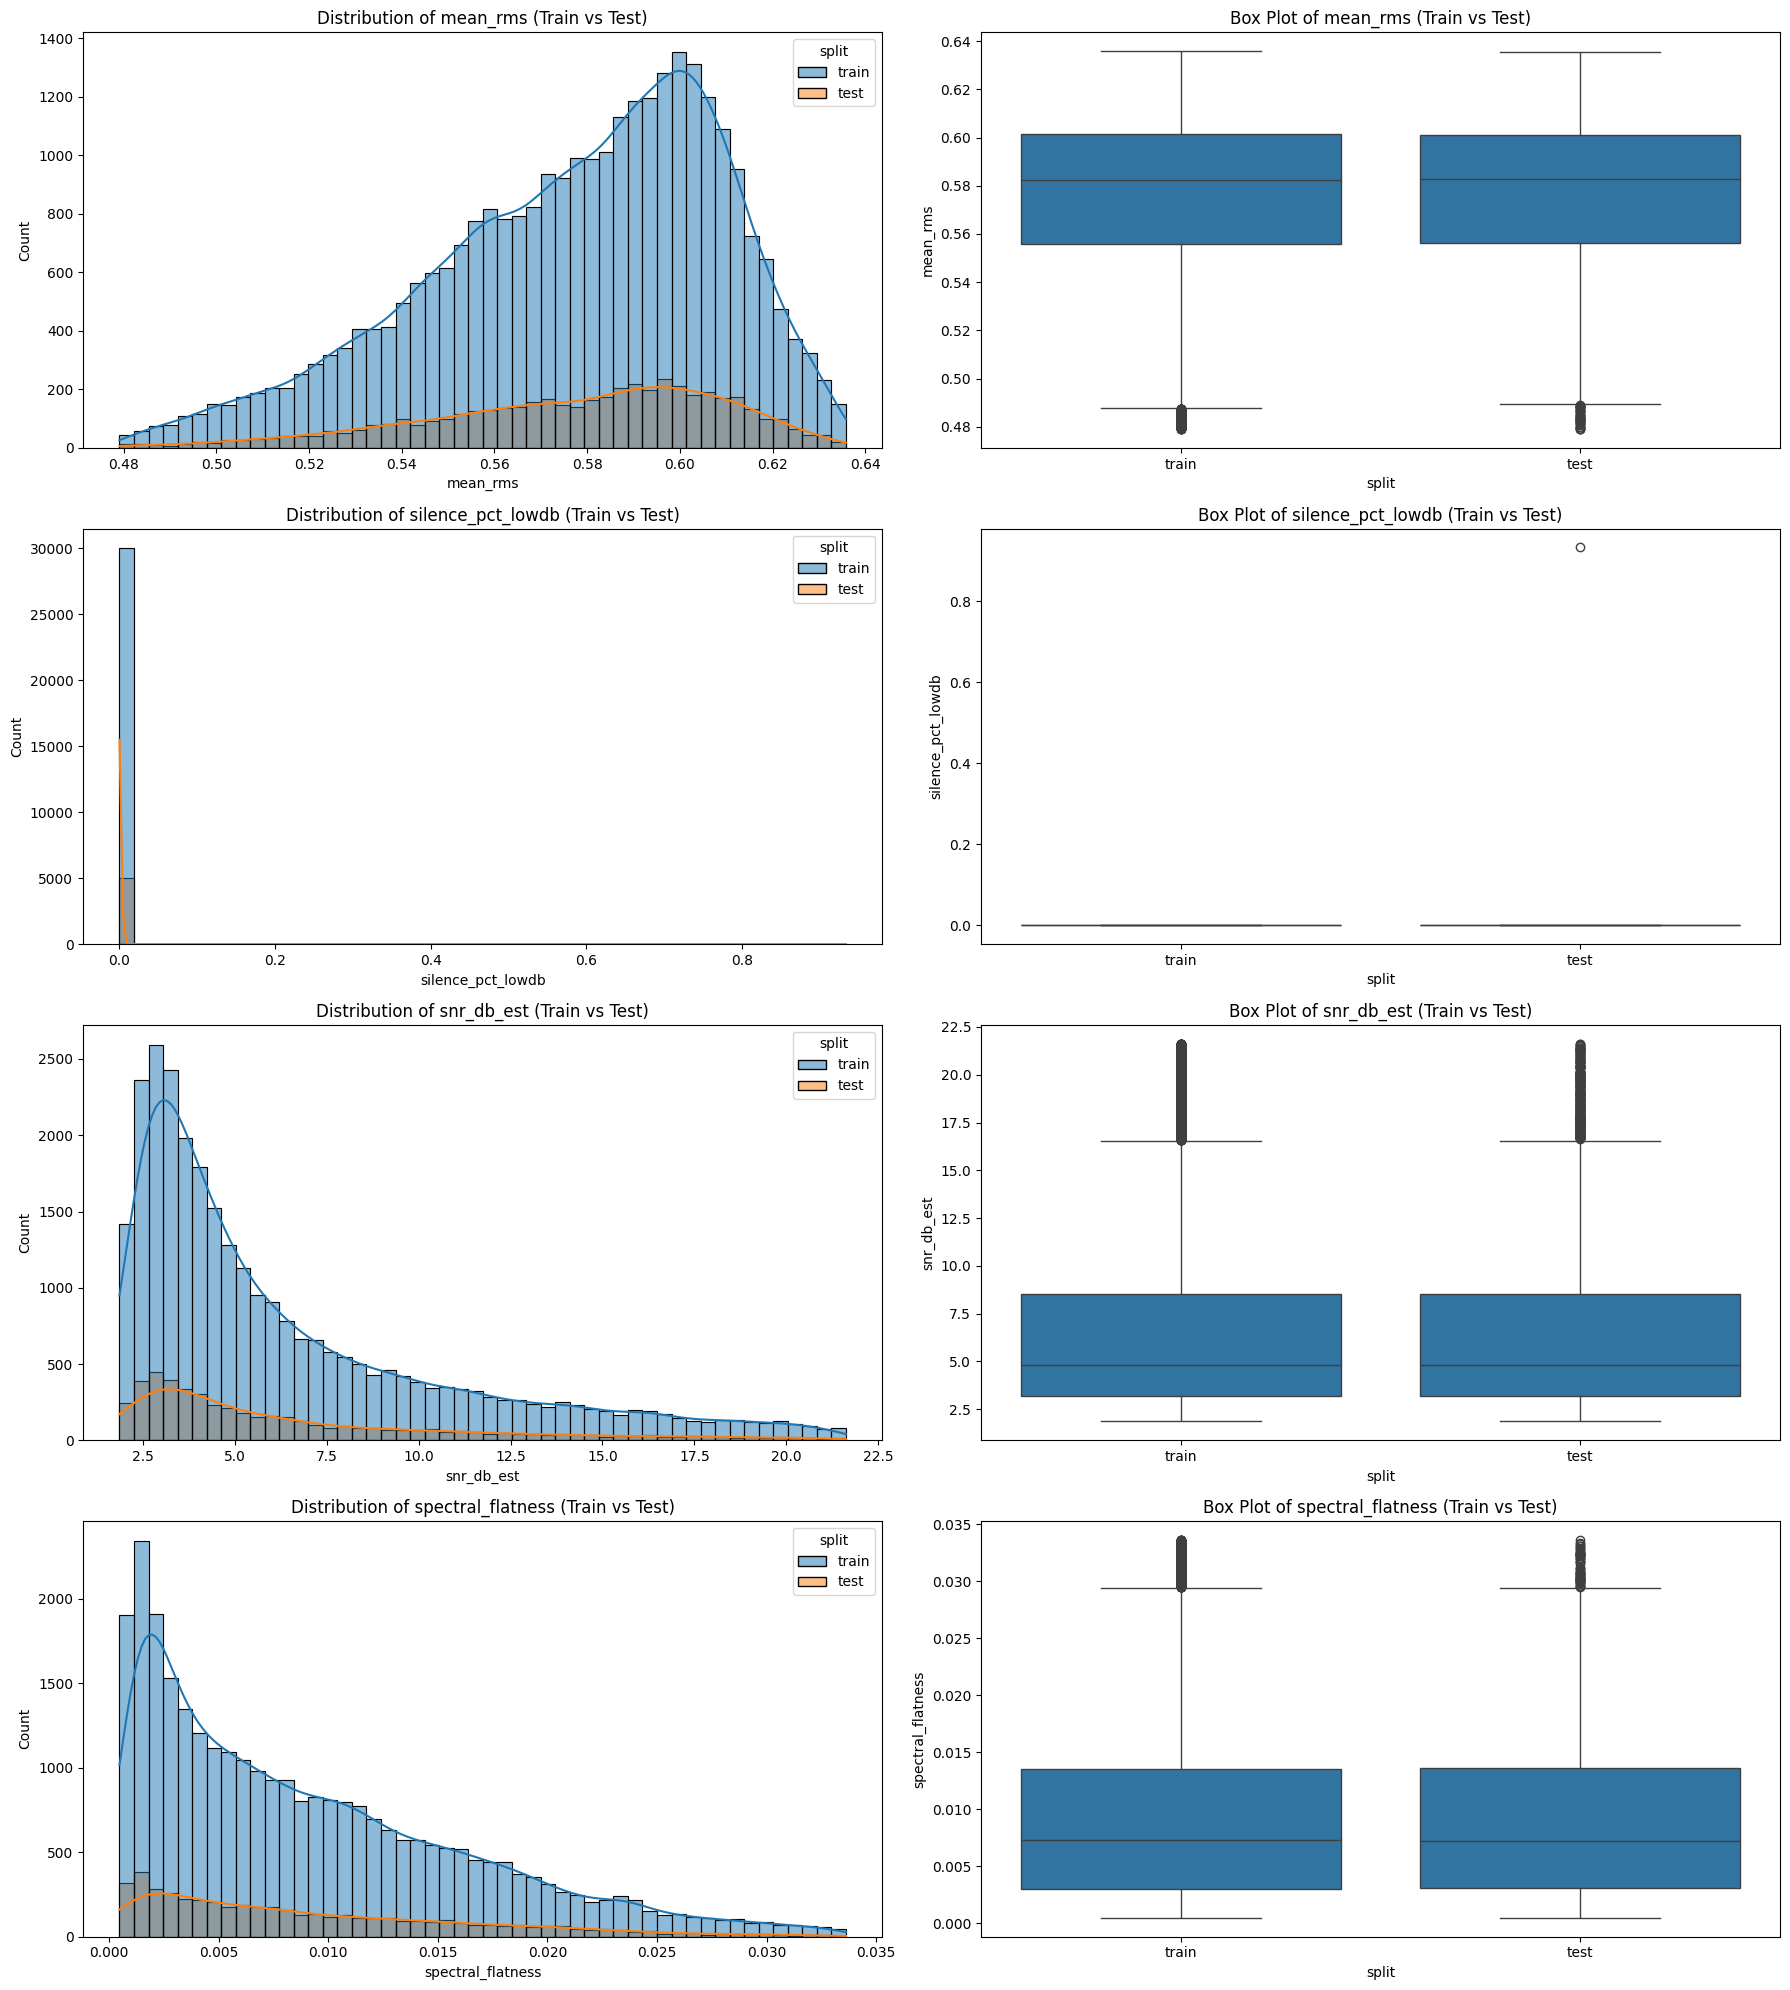


Visualizing example Mel Spectrograms (Train vs Test)...
Spectrogram comparison plot saved to /content/spectrogram_comparison_noise_analysis.png


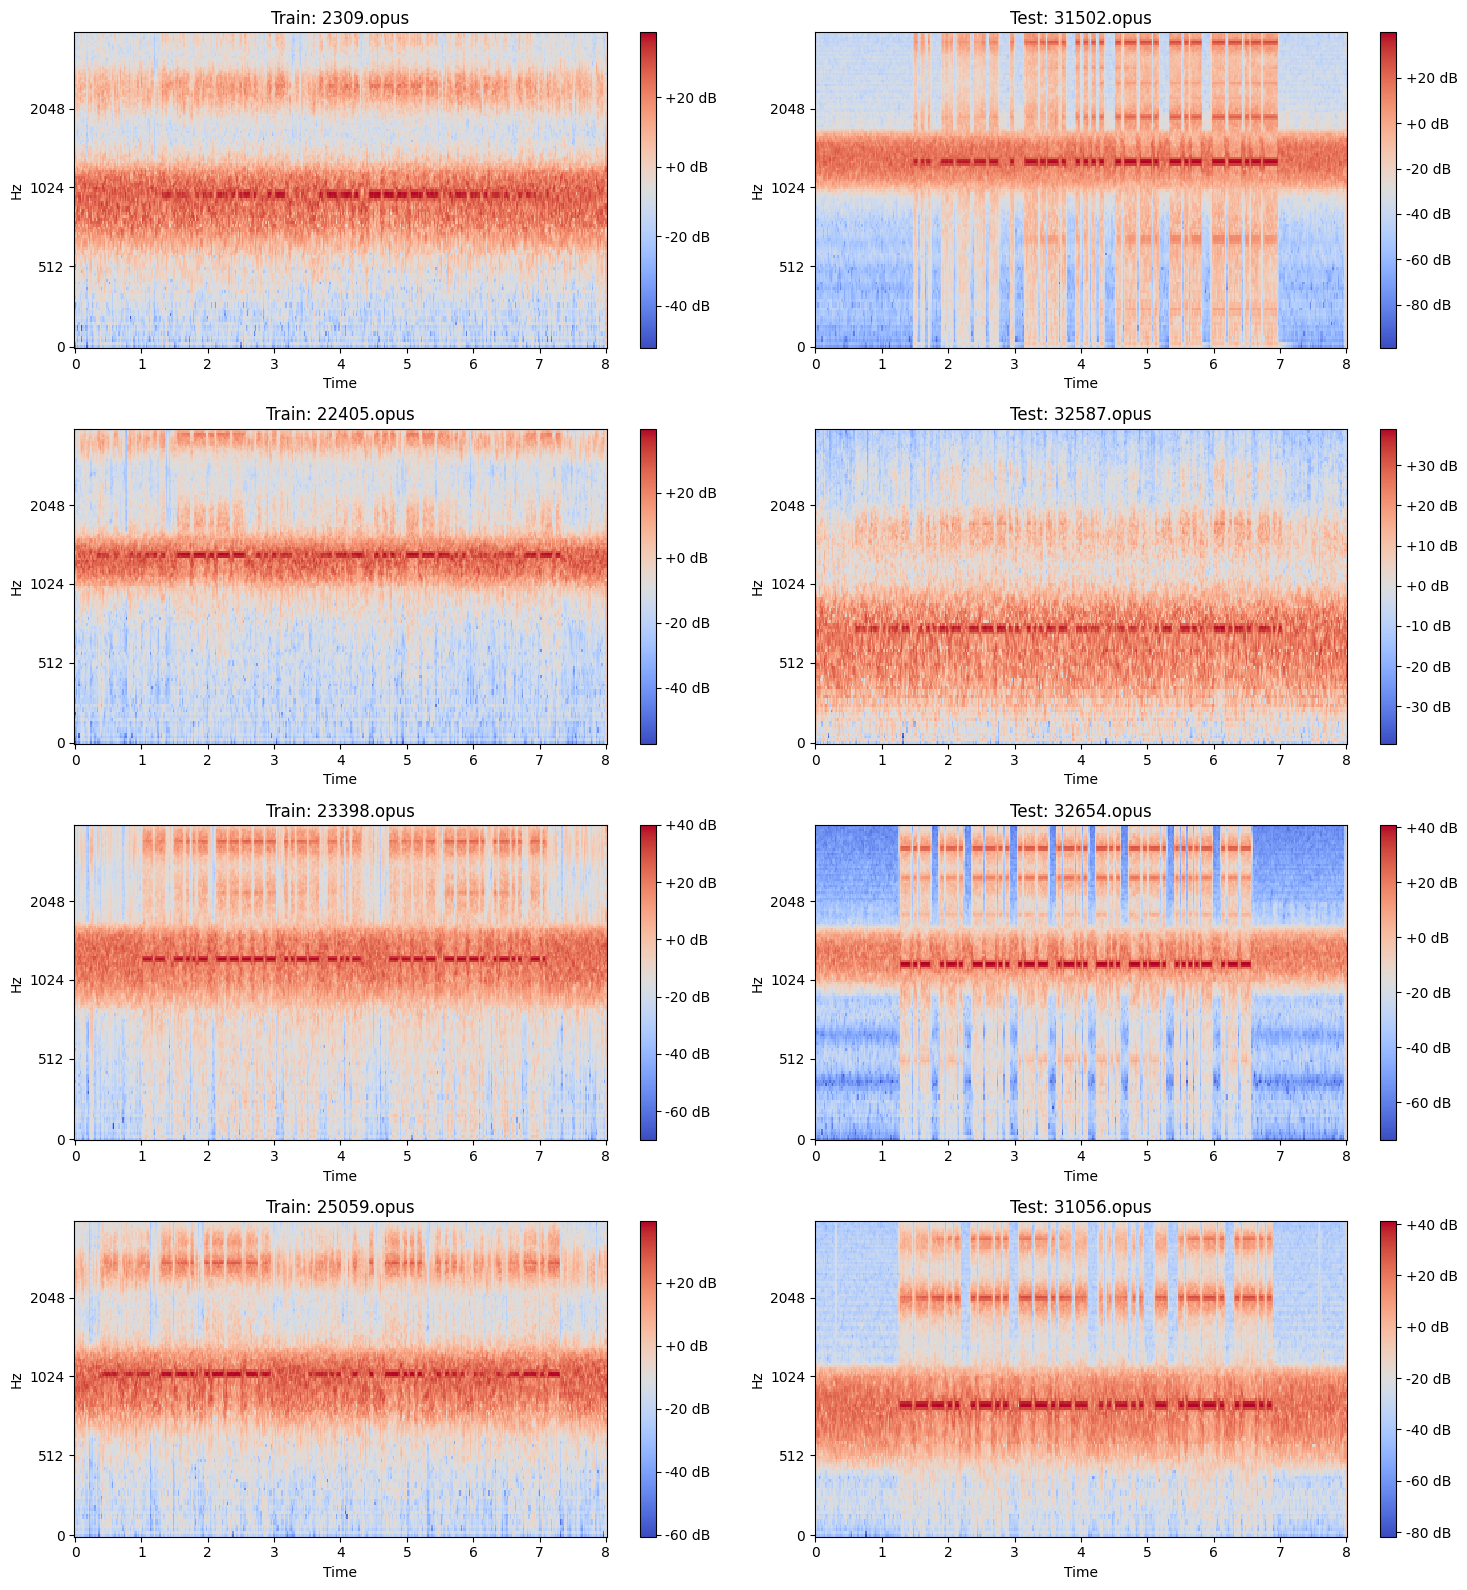


--- Noise Analysis Complete ---


In [ ]:
# --- Конфигурация ---
KAGGLE_INPUT_DIR = '/content/gdfag3424'
KAGGLE_WORKING_DIR = "/content/"

IS_KAGGLE = os.path.exists(KAGGLE_INPUT_DIR)

if IS_KAGGLE:
    DATA_DIR = KAGGLE_INPUT_DIR
    OUTPUT_DIR = KAGGLE_WORKING_DIR
else:
    BASE_PROJECT_DIR = r'.'
    DATA_DIR = os.path.join(BASE_PROJECT_DIR, 'kaggle_data')
    OUTPUT_DIR = os.path.join(BASE_PROJECT_DIR, 'output_analysis')
    if not os.path.exists(DATA_DIR): print(f"Error: Local data directory not found at {DATA_DIR}"); exit()

AUDIO_DIR_RELATIVE = os.path.join('morse_dataset', 'morse_dataset')
AUDIO_DIR = os.path.join(DATA_DIR, AUDIO_DIR_RELATIVE)
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV = os.path.join(DATA_DIR, "test.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Параметры Анализа ---
SAMPLE_RATE = 8000
SILENCE_TOP_DB_LOW = 30 # Низкий порог для оценки шума в паузах
EPSILON = 1e-10 # Малое число для избежания деления на ноль / логарифма нуля
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Вспомогательные функции ---

def load_audio_safe(file_path, target_sr=SAMPLE_RATE):
    try:
        waveform, sr = torchaudio.load(file_path)
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sr != target_sr: waveform = T.Resample(sr, target_sr)(waveform)
        # Нормализация амплитуды (может помочь стабилизировать RMS/SNR)
        waveform = waveform / torch.max(torch.abs(waveform))
        return waveform, target_sr
    except FileNotFoundError: return None, None
    except Exception as e: return None, None

def calculate_duration_ms(waveform, sr):
    if waveform is None: return 0
    return int((waveform.shape[-1] / sr) * 1000)

def calculate_rms(waveform):
    if waveform is None: return 0.0
    # Используем torch для RMS
    rms_val = torch.sqrt(torch.mean(waveform**2)).item()
    return rms_val

def calculate_silence_percent(waveform, sr, top_db=SILENCE_TOP_DB_LOW):
    # (Код остается тем же, но вызывается с низким top_db)
    if waveform is None: return 100.0
    try:
        non_silent_intervals = librosa.effects.split(y=waveform.squeeze().numpy(), top_db=top_db)
        if non_silent_intervals.size == 0: return 100.0
        non_silent_duration_samples = np.sum(non_silent_intervals[:, 1] - non_silent_intervals[:, 0])
        total_duration_samples = waveform.shape[-1]
        if total_duration_samples == 0: return 100.0
        silent_duration_samples = total_duration_samples - non_silent_duration_samples
        return (silent_duration_samples / total_duration_samples) * 100.0
    except Exception: return np.nan

def estimate_snr_db(waveform, sr, frame_length=512, hop_length=160, noise_percentile=10, signal_percentile=90):
    """ Грубая оценка SNR в dB """
    if waveform is None: return np.nan
    try:
        # RMS по фреймам
        rms_frames = librosa.feature.rms(y=waveform.squeeze().numpy(), frame_length=frame_length, hop_length=hop_length)[0]
        rms_frames = rms_frames[rms_frames > EPSILON] # Убираем нулевые/очень малые значения
        if len(rms_frames) < 2: return np.nan # Недостаточно фреймов для перцентилей

        # Оценка уровня шума (тихие фреймы)
        noise_level = np.percentile(rms_frames, noise_percentile)
        # Оценка уровня сигнала+шума (громкие фреймы)
        signal_level = np.percentile(rms_frames, signal_percentile)

        if noise_level < EPSILON: noise_level = EPSILON # Избегаем деления на ноль

        # Отношение сигнал/шум (по мощности/энергии пропорционально квадрату RMS)
        snr_ratio = (signal_level**2) / (noise_level**2)

        # Перевод в dB
        snr_db = 10 * math.log10(snr_ratio + EPSILON) # Добавляем EPSILON на всякий случай
        return snr_db
    except Exception: return np.nan

def calculate_spectral_flatness(waveform, sr, n_fft=400, hop_length=160):
    """ Расчет средней спектральной гладкости """
    if waveform is None: return np.nan
    try:
        flatness = librosa.feature.spectral_flatness(y=waveform.squeeze().numpy(), n_fft=n_fft, hop_length=hop_length)[0]
        return np.mean(flatness)
    except Exception: return np.nan

# --- Основная функция анализа ---

def analyze_noise_data(df, split_name, audio_dir):
    """ Извлекает характеристики, связанные с шумом. """
    results = []
    print(f"\nAnalyzing noise characteristics for {len(df)} files from {split_name} split...")
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Analyzing {split_name}"):
        file_id = row['id']
        file_path = os.path.join(audio_dir, file_id)
        waveform, sr = load_audio_safe(file_path, SAMPLE_RATE)

        if waveform is not None:
            duration = calculate_duration_ms(waveform, sr) # Все еще полезно иметь
            rms = calculate_rms(waveform)
            silence_pct = calculate_silence_percent(waveform, sr, top_db=SILENCE_TOP_DB_LOW)
            snr_est = estimate_snr_db(waveform, sr)
            spec_flat = calculate_spectral_flatness(waveform, sr)
            results.append({
                'id': file_id,
                'split': split_name,
                'duration_ms': duration,
                'mean_rms': rms,
                'silence_pct_lowdb': silence_pct,
                'snr_db_est': snr_est,
                'spectral_flatness': spec_flat
            })
        else:
             results.append({ # Запись об ошибке
                'id': file_id, 'split': split_name, 'duration_ms': 0,
                'mean_rms': 0.0, 'silence_pct_lowdb': 100.0,
                'snr_db_est': np.nan, 'spectral_flatness': np.nan
            })
    return pd.DataFrame(results)

# --- Загрузка данных ---
print("Loading CSV files...")
try:
    train_df = pd.read_csv(TRAIN_CSV)
    test_df = pd.read_csv(TEST_CSV)
except FileNotFoundError as e: print(f"Error loading CSV: {e}"); exit()

# --- Извлечение характеристик (с кэшированием) ---
noise_features_cache_path = os.path.join(OUTPUT_DIR, "audio_noise_features_analysis.csv")

if os.path.exists(noise_features_cache_path):
    print(f"Loading cached noise features from {noise_features_cache_path}...")
    analysis_df_noise = pd.read_csv(noise_features_cache_path)
    # Простая проверка, что оба сплита присутствуют
    if 'train' in analysis_df_noise['split'].unique() and 'test' in analysis_df_noise['split'].unique():
        print("Using cached noise features.")
        needs_noise_analysis = False
    else:
        print("Cache seems incomplete. Re-analyzing noise features...")
        needs_noise_analysis = True
else:
    print("Noise features cache not found. Starting noise analysis...")
    needs_noise_analysis = True

if needs_noise_analysis:
    train_noise_features = analyze_noise_data(train_df, 'train', AUDIO_DIR)
    test_noise_features = analyze_noise_data(test_df, 'test', AUDIO_DIR)
    analysis_df_noise = pd.concat([train_noise_features, test_noise_features], ignore_index=True)

    # Обработка NaN значений (заполняем медианой по сплиту)
    for col in ['silence_pct_lowdb', 'snr_db_est', 'spectral_flatness']:
        analysis_df_noise[col] = analysis_df_noise.groupby('split')[col].transform(lambda x: x.fillna(x.median()))
        # Если медиана тоже NaN (например, все значения NaN), заполняем нулем
        analysis_df_noise[col].fillna(0, inplace=True)

    print(f"Saving calculated noise features to {noise_features_cache_path}...")
    analysis_df_noise.to_csv(noise_features_cache_path, index=False)

# --- Анализ и Визуализация ---
print("\n--- Noise Analysis Results ---")

# 1. Описательные статистики
print("\nDescriptive Statistics (Noise Related):")
print(analysis_df_noise.groupby('split').agg(
    count=('id', 'size'),
    mean_rms=('mean_rms', 'mean'), # Повторяем для контекста
    std_rms=('mean_rms', 'std'),
    mean_silence_lowdb=('silence_pct_lowdb', 'mean'),
    std_silence_lowdb=('silence_pct_lowdb', 'std'),
    mean_snr_est=('snr_db_est', 'mean'),
    std_snr_est=('snr_db_est', 'std'),
    mean_spec_flat=('spectral_flatness', 'mean'),
    std_spec_flat=('spectral_flatness', 'std')
).round(3)) # Увеличил точность до 3 знаков

# 2. Визуализация распределений
features_to_plot_noise = ['mean_rms', 'silence_pct_lowdb', 'snr_db_est', 'spectral_flatness']
n_features_noise = len(features_to_plot_noise)
plt.figure(figsize=(18, 5 * n_features_noise))
plot_num = 1

for feature in features_to_plot_noise:
    # Убираем крайние выбросы для визуализации
    q_low = analysis_df_noise[feature].quantile(0.01)
    q_high = analysis_df_noise[feature].quantile(0.99)
    # Добавим проверку, что q_low < q_high
    if q_low < q_high:
        df_plot = analysis_df_noise[(analysis_df_noise[feature] >= q_low) & (analysis_df_noise[feature] <= q_high)]
    else: # Если квантили совпадают или инвертированы, берем все данные
        df_plot = analysis_df_noise

    # Гистограмма + KDE
    plt.subplot(n_features_noise, 2, plot_num)
    sns.histplot(data=df_plot, x=feature, hue='split', kde=True, bins=50)
    plt.title(f'Distribution of {feature} (Train vs Test)')
    plot_num += 1

    # Box Plot
    plt.subplot(n_features_noise, 2, plot_num)
    sns.boxplot(data=df_plot, x='split', y=feature)
    plt.title(f'Box Plot of {feature} (Train vs Test)')
    plot_num += 1

plt.tight_layout()
noise_dist_plot_path = os.path.join(OUTPUT_DIR, "noise_feature_distributions.png")
plt.savefig(noise_dist_plot_path)
print(f"\nNoise feature distribution plots saved to {noise_dist_plot_path}")
plt.show()
plt.close()

# 3. Визуализация спектрограмм (повторяем для наглядности)
print("\nVisualizing example Mel Spectrograms (Train vs Test)...")
n_examples = 4
mel_transform = T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=400, hop_length=160, n_mels=128).cpu()
plt.figure(figsize=(15, 4 * n_examples))
# Используем ID из analysis_df_noise, чтобы гарантировать наличие файлов
train_sample_ids = analysis_df_noise[analysis_df_noise['split'] == 'train']['id'].sample(n_examples, random_state=SEED).tolist()
test_sample_ids = analysis_df_noise[analysis_df_noise['split'] == 'test']['id'].sample(n_examples, random_state=SEED).tolist()
# (Код отрисовки спектрограмм остается таким же, как в предыдущем скрипте анализа)
for i in range(n_examples):
    train_id = train_sample_ids[i]; train_path = os.path.join(AUDIO_DIR, train_id); train_wf, _ = load_audio_safe(train_path, SAMPLE_RATE)
    if train_wf is not None:
        train_mel = mel_transform(train_wf).squeeze(0); train_mel_db = T.AmplitudeToDB()(train_mel)
        plt.subplot(n_examples, 2, 2*i + 1); librosa.display.specshow(train_mel_db.numpy(), sr=SAMPLE_RATE, hop_length=160, x_axis='time', y_axis='mel'); plt.colorbar(format='%+2.0f dB'); plt.title(f'Train: {train_id}')
    else: plt.subplot(n_examples, 2, 2*i + 1); plt.title(f'Train: {train_id} (Error)'); plt.text(0.5, 0.5, 'Error Loading', ha='center', va='center')
    test_id = test_sample_ids[i]; test_path = os.path.join(AUDIO_DIR, test_id); test_wf, _ = load_audio_safe(test_path, SAMPLE_RATE)
    if test_wf is not None:
        test_mel = mel_transform(test_wf).squeeze(0); test_mel_db = T.AmplitudeToDB()(test_mel)
        plt.subplot(n_examples, 2, 2*i + 2); librosa.display.specshow(test_mel_db.numpy(), sr=SAMPLE_RATE, hop_length=160, x_axis='time', y_axis='mel'); plt.colorbar(format='%+2.0f dB'); plt.title(f'Test: {test_id}')
    else: plt.subplot(n_examples, 2, 2*i + 2); plt.title(f'Test: {test_id} (Error)'); plt.text(0.5, 0.5, 'Error Loading', ha='center', va='center')
plt.tight_layout()
spec_plot_path = os.path.join(OUTPUT_DIR, "spectrogram_comparison_noise_analysis.png")
plt.savefig(spec_plot_path)
print(f"Spectrogram comparison plot saved to {spec_plot_path}")
plt.show()
plt.close()


print("\n--- Noise Analysis Complete ---")

# Обучение модели

In [ ]:
# --- Конфигурация ---
KAGGLE_INPUT_DIR = '/content/gdfag3424'
KAGGLE_WORKING_DIR = "/content/"

DATA_DIR = '/content/gdfag3424'
OUTPUT_DIR = "/content/"

IS_KAGGLE = True

NUM_WORKERS = 12

AUDIO_DIR_RELATIVE = os.path.join('morse_dataset', 'morse_dataset')
AUDIO_DIR = os.path.join(DATA_DIR, AUDIO_DIR_RELATIVE)
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV = os.path.join(DATA_DIR, "test.csv")
SAMPLE_SUBMISSION_CSV = os.path.join(DATA_DIR, "sample_submission.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Параметры Предобработки ---
SAMPLE_RATE = 8000; N_MELS = 128; N_FFT = 400; HOP_LENGTH = 160

# --- Параметры Модели (как в лучшей + SE/Projection) ---
CNN_OUT_CHANNELS = 64
RNN_HIDDEN_SIZE = 512
RNN_LAYERS = 3
RNN_TYPE = 'GRU' # Оставляем GRU
NUM_HEADS = 8
DROPOUT = 0.45
SE_REDUCTION = 16 # Коэффициент сжатия в SE-блоках

# --- Параметры Аугментации (SpecAugment) ---
FREQ_MASK_PARAM = 30
TIME_MASK_PARAM = 60

# --- Параметры Обучения ---
SEED = 42; BATCH_SIZE = 64; EPOCHS = 50
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 1e-5
CLIP_GRAD_NORM = 1.0
EARLY_STOPPING_PATIENCE = 10

# --- Утилиты ---
def seed_everything(seed):
    random.seed(seed); os.environ['PYTHONHASHSEED'] = str(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed(seed); torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
def clean_text(text):
    if not isinstance(text, str): text = str(text)
    return text.strip()

# --- Воспроизводимость, Device, Путь к аудио ---
seed_everything(SEED); device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"Using device: {device}")
if not os.path.isdir(AUDIO_DIR):
    ALT_AUDIO_DIR = os.path.join(DATA_DIR, 'morse_dataset/morse_dataset/')
    if os.path.isdir(ALT_AUDIO_DIR): AUDIO_DIR = ALT_AUDIO_DIR; print(f"Audio directory found at alternative path: {AUDIO_DIR}")
    else: print(f"Error: Audio directory not found at {AUDIO_DIR} or {ALT_AUDIO_DIR}"); exit()
else: print(f"Audio directory found at: {AUDIO_DIR}")

# --- Загрузка CSV, Словарь ---
try: train_df = pd.read_csv(TRAIN_CSV); test_df = pd.read_csv(TEST_CSV); sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION_CSV)
except FileNotFoundError as e: print(f"Error loading CSV files: {e}"); exit()
train_df['message'] = train_df['message'].apply(clean_text)

train_df = train_df[train_df['message'].str.len() > 0].reset_index(drop=True)
print(f"Train df shape after cleaning: {train_df.shape}")
if train_df.empty: print("Error: No valid training data after cleaning."); exit()

all_chars = Counter("".join(train_df['message'])); BLANK_CHAR = "_";
vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]; vocab_size = len(vocab_list)
char_to_int = {char: i for i, char in enumerate(vocab_list)}; int_to_char = {i: char for i, char in enumerate(vocab_list)}; BLANK_IDX = char_to_int[BLANK_CHAR];
print(f"\nVocabulary: {''.join(vocab_list)}"); print(f"Vocabulary size (incl. blank): {vocab_size}")

# --- Предобработка аудио и Dataset (SpecAugment) ---
eval_audio_transform = T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS).cpu()
train_audio_transform = nn.Sequential(
    T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    T.FrequencyMasking(freq_mask_param=FREQ_MASK_PARAM),
    T.TimeMasking(time_mask_param=TIME_MASK_PARAM)
).cpu()

class MorseDataset(Dataset):
    def __init__(self, df, audio_dir, char_map, audio_transform=None, is_test=False):
        self.df = df; self.audio_dir = audio_dir; self.char_map = char_map
        self.audio_transform = audio_transform.cpu() if audio_transform is not None else None
        self.is_test = is_test; self.int_to_char = {v: k for k, v in char_map.items()}
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]; file_id = row['id']; audio_path = os.path.join(self.audio_dir, file_id)
        try:
            waveform, sr = torchaudio.load(audio_path)
            if sr != SAMPLE_RATE: waveform = T.Resample(sr, SAMPLE_RATE)(waveform)
            current_transform = self.audio_transform if not self.is_test and self.audio_transform else eval_audio_transform
            spectrogram = current_transform(waveform).squeeze(0).unsqueeze(0) # (1, M, T)
            if not self.is_test:
                text = row['message']; target = torch.tensor([self.char_map[char] for char in text], dtype=torch.long); target_len = torch.tensor(len(target), dtype=torch.long)
                # Возвращаем spec_length, хотя он будет одинаковым для трейна
                return spectrogram, target, spectrogram.shape[-1], target_len
            else: return spectrogram, spectrogram.shape[-1], file_id
        except Exception: pass
        if not self.is_test: return None, None, None, None
        else: return None, None, file_id

# --- collate_fn и collate_fn_inference ---
def collate_fn(batch):
    valid_batch = [item for item in batch if item[0] is not None]
    if not valid_batch: return None, None, None, None, None
    is_test_batch = len(valid_batch[0]) == 3
    if not is_test_batch: spectrograms, targets, spec_lengths, target_lengths = zip(*valid_batch); ids = None
    else: spectrograms, spec_lengths, ids = zip(*valid_batch); targets, target_lengths = None, None
    spectrograms_permuted = [s.squeeze(0).permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)
    spec_lengths_tensor = torch.tensor(spec_lengths, dtype=torch.long)
    if not is_test_batch:
        targets_padded = nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=BLANK_IDX)
        target_lengths_tensor = torch.tensor(target_lengths, dtype=torch.long)
        return spectrograms_padded, spec_lengths_tensor, targets_padded, target_lengths_tensor, None
    else: return spectrograms_padded, spec_lengths_tensor, None, None, list(ids)
def collate_fn_inference(batch):
    valid_batch = [item for item in batch if item[0] is not None]
    error_ids = [item[2] for item in batch if item[0] is None]
    if not valid_batch: return None, None, None, error_ids
    spectrograms, spec_lengths, ids = zip(*valid_batch)
    spectrograms_permuted = [s.squeeze(0).permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)
    spec_lengths_tensor = torch.tensor(spec_lengths, dtype=torch.long)
    return spectrograms_padded, spec_lengths_tensor, list(ids), error_ids

# --- Разделение данных (простое случайное) ---
print("Splitting data randomly...")
train_data_df, val_data_df = train_test_split(train_df, test_size=0.15, random_state=SEED)

# --- Создание DataLoader ---
print(f"Using num_workers = {NUM_WORKERS}")
pin_memory_flag = True if device == 'cuda' else False
train_dataset = MorseDataset(train_data_df, AUDIO_DIR, char_to_int, audio_transform=train_audio_transform)
val_dataset = MorseDataset(val_data_df, AUDIO_DIR, char_to_int, audio_transform=eval_audio_transform)
test_dataset = MorseDataset(test_df, AUDIO_DIR, char_to_int, audio_transform=eval_audio_transform, is_test=True)
# Используем shuffle=True для train_loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=pin_memory_flag)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=NUM_WORKERS, pin_memory=pin_memory_flag)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, collate_fn=collate_fn_inference, num_workers=NUM_WORKERS, pin_memory=pin_memory_flag)
print("DataLoaders created.")

# --- Определение Модели CRNN_SE_Proj ---
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__(); self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(nn.Linear(channel, channel // reduction, bias=False), nn.GELU(), nn.Linear(channel // reduction, channel, bias=False), nn.Sigmoid())
    def forward(self, x):
        b, c, _, _ = x.size(); y = self.avg_pool(x).view(b, c); y = self.fc(y).view(b, c, 1, 1); return x * y.expand_as(x)
class CRNN_SE_Proj(nn.Module):
    def __init__(self, n_mels, cnn_out_channels, rnn_hidden, rnn_layers, num_heads, num_classes, dropout, se_reduction=16):
        super().__init__(); self.n_mels = n_mels
        cnn_ch1 = cnn_out_channels; cnn_ch2 = cnn_out_channels * 2
        self.cnn = nn.Sequential(
            nn.Conv2d(1, cnn_ch1, 3, 1, 1), nn.BatchNorm2d(cnn_ch1), nn.GELU(), nn.MaxPool2d((1, 2), (1, 2)),
            nn.Conv2d(cnn_ch1, cnn_ch1, 3, 1, 1), nn.BatchNorm2d(cnn_ch1), nn.GELU(), SEBlock(cnn_ch1, se_reduction), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(cnn_ch1, cnn_ch2, 3, 1, 1), nn.BatchNorm2d(cnn_ch2), nn.GELU(), nn.MaxPool2d((2, 2), (2, 2)),
            nn.Conv2d(cnn_ch2, cnn_ch2, 3, 1, 1), nn.BatchNorm2d(cnn_ch2), nn.GELU(), SEBlock(cnn_ch2, se_reduction), nn.MaxPool2d((2, 1), (2, 1))
        )
        with torch.no_grad(): dummy_input = torch.randn(1, 1, n_mels, 400); cnn_out = self.cnn(dummy_input); self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]
        print(f"CNN output shape (dummy): {cnn_out.shape}"); print(f"CNN output features: {self.cnn_output_features}")
        self.projection_dim = rnn_hidden * 2; self.cnn_to_rnn_proj = nn.Linear(self.cnn_output_features, self.projection_dim); self.cnn_to_rnn_act = nn.GELU()
        print(f"Projection from {self.cnn_output_features} to {self.projection_dim}")
        self.rnn = nn.GRU(self.projection_dim, rnn_hidden, rnn_layers, bidirectional=True, dropout=dropout if rnn_layers > 1 else 0, batch_first=True)
        self.mha_embed_dim = rnn_hidden * 2
        if self.mha_embed_dim % num_heads != 0: raise ValueError(f"embed_dim ({self.mha_embed_dim}) must be divisible by num_heads ({num_heads})")
        self.mha = nn.MultiheadAttention(self.mha_embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.dropout_mha = nn.Dropout(dropout); self.layer_norm = nn.LayerNorm(self.mha_embed_dim)
        self.fc = nn.Linear(self.mha_embed_dim, num_classes)
    def _get_output_lengths(self, input_lengths):
        output_lengths = torch.floor(input_lengths.float() / 4); return torch.clamp(output_lengths.long(), min=1)
    def forward(self, x, input_lengths):
        x = self.cnn(x); batch_size, _, _, time_cnn_padded = x.shape
        x = x.permute(0, 3, 1, 2).contiguous().view(batch_size, time_cnn_padded, self.cnn_output_features)
        x = self.cnn_to_rnn_proj(x); x = self.cnn_to_rnn_act(x)
        output_lengths = self._get_output_lengths(input_lengths)
        if torch.any(output_lengths <= 0): pass
        valid_pack_indices = output_lengths > 0
        if not torch.all(valid_pack_indices):
             print("Warning: Zero output lengths detected before packing."); zero_log_probs = torch.full((time_cnn_padded, batch_size, self.fc.out_features), -float('inf'), device=x.device); zero_log_probs[:, :, BLANK_IDX] = 0; return zero_log_probs, output_lengths
        packed_input = nn.utils.rnn.pack_padded_sequence(x, output_lengths.cpu(), batch_first=True, enforce_sorted=False)
        self.rnn.flatten_parameters(); packed_output, _ = self.rnn(packed_input)
        gru_output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True, total_length=time_cnn_padded)
        max_len = time_cnn_padded; idx = torch.arange(max_len, device=x.device).unsqueeze(0); key_padding_mask = (idx >= output_lengths.unsqueeze(1))
        attn_output, _ = self.mha(gru_output, gru_output, gru_output, key_padding_mask=key_padding_mask)
        x = gru_output + self.dropout_mha(attn_output); x = self.layer_norm(x)
        x = self.fc(x); log_probs = nn.functional.log_softmax(x.permute(1, 0, 2), dim=2); return log_probs, output_lengths

# --- Инициализация модели, лосса, оптимизатора ---
model = CRNN_SE_Proj(
    n_mels=N_MELS, cnn_out_channels=CNN_OUT_CHANNELS,
    rnn_hidden=RNN_HIDDEN_SIZE, rnn_layers=RNN_LAYERS,
    num_heads=NUM_HEADS, num_classes=vocab_size, dropout=DROPOUT,
    se_reduction=SE_REDUCTION
).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nCRNN_SE_Proj Model Initialized. Trainable Parameters: {total_params:,}")

criterion = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=6, verbose=True)

# --- Функции декодера (Greedy) и метрики---
def ctc_greedy_decoder(log_probs, labels_map, blank_label_idx):
    decoded_preds = []; log_probs_cpu = log_probs.cpu(); max_indices = torch.argmax(log_probs_cpu.detach(), dim=2).t().numpy()
    for indices in max_indices:
        merged_indices = []; last_idx = -1
        for idx in indices:
            if idx != last_idx:
                if idx != blank_label_idx: merged_indices.append(idx)
                last_idx = idx
        text = "".join([labels_map.get(i, '?') for i in merged_indices]); decoded_preds.append(text)
    return decoded_preds
def calculate_levenshtein(predictions, targets, target_lengths, int_to_char_map, blank_idx):
    total_distance = 0; total_target_len_sum = 0; batch_size = len(predictions); all_true_texts = []
    targets_cpu = targets.cpu(); target_lengths_cpu = target_lengths.cpu()
    for i in range(batch_size):
        pred_text = predictions[i]; actual_len = min(target_lengths_cpu[i].item(), targets_cpu[i].size(0)); target_tensor = targets_cpu[i][:actual_len]
        true_text = "".join([int_to_char_map.get(idx.item(), '?') for idx in target_tensor if idx.item() != blank_idx]); all_true_texts.append(true_text)
        distance = Levenshtein.distance(pred_text, true_text); total_distance += distance; total_target_len_sum += len(true_text)
    mean_distance = total_distance / batch_size if batch_size > 0 else 0
    return total_distance, mean_distance, all_true_texts

# --- Циклы обучения и валидации ---
def train_epoch(model, dataloader, criterion, optimizer, device, clip_norm):
    model.train(); total_loss = 0.0; processed_batches = 0
    pbar = tqdm(dataloader, desc="Training", leave=True)
    for batch_idx, batch in enumerate(pbar):
        if batch[0] is None: continue
        spectrograms, spec_lengths, targets, target_lengths, _ = batch
        spectrograms = spectrograms.to(device, non_blocking=True); spec_lengths = spec_lengths.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True); target_lengths = target_lengths.to(device, non_blocking=True)
        optimizer.zero_grad()
        try: log_probs, output_lengths = model(spectrograms, spec_lengths)
        except Exception as e: print(f"\nError forward train (batch {batch_idx}): {e}"); optimizer.zero_grad(); continue
        valid_indices = (output_lengths > 0) & (target_lengths > 0) & (target_lengths <= output_lengths)
        if not torch.any(valid_indices): optimizer.zero_grad(); continue
        log_probs_filt = log_probs[:, valid_indices, :]; targets_filt = targets[valid_indices]
        output_lengths_filt = output_lengths[valid_indices]; target_lengths_filt = target_lengths[valid_indices]
        if log_probs_filt.numel() == 0 or targets_filt.numel() == 0 or log_probs_filt.size(0) == 0: optimizer.zero_grad(); continue
        try: loss = criterion(log_probs_filt, targets_filt, output_lengths_filt, target_lengths_filt)
        except RuntimeError as e: print(f"\nRuntimeError train loss (batch {batch_idx}): {e}"); optimizer.zero_grad(); continue
        if torch.isnan(loss) or torch.isinf(loss): print(f"\nWarning: NaN/Inf loss train (batch {batch_idx}): {loss.item()}"); optimizer.zero_grad(); continue
        loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), clip_norm); optimizer.step()
        total_loss += loss.item(); processed_batches += 1; pbar.set_postfix(loss=f"{loss.item():.4f}", avg_loss=f"{total_loss / processed_batches:.4f}")
    return total_loss / processed_batches if processed_batches > 0 else 0.0
def validate_epoch(model, dataloader, criterion, device, int_to_char_map, blank_idx):
    model.eval(); total_loss = 0.0; total_lev_sum = 0; total_samples = 0; processed_batches = 0
    all_predictions = []; all_true_texts_val = []
    pbar = tqdm(dataloader, desc="Validating", leave=True)
    with torch.no_grad():
        for batch in pbar:
            if batch[0] is None: continue
            spectrograms, spec_lengths, targets, target_lengths, _ = batch
            spectrograms = spectrograms.to(device, non_blocking=True); spec_lengths = spec_lengths.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True); target_lengths = target_lengths.to(device, non_blocking=True)
            try: log_probs, output_lengths = model(spectrograms, spec_lengths)
            except Exception as e: print(f"\nError forward val: {e}"); continue
            valid_indices = (output_lengths > 0) & (target_lengths > 0) & (target_lengths <= output_lengths)
            loss = torch.tensor(0.0, device=device)
            if torch.any(valid_indices):
                log_probs_filt = log_probs[:, valid_indices, :]; targets_filt = targets[valid_indices]
                output_lengths_filt = output_lengths[valid_indices]; target_lengths_filt = target_lengths[valid_indices]
                if log_probs_filt.numel() > 0 and targets_filt.numel() > 0 and log_probs_filt.size(0) > 0:
                    try:
                        batch_loss = criterion(log_probs_filt, targets_filt, output_lengths_filt, target_lengths_filt)
                        if not (torch.isnan(batch_loss) or torch.isinf(batch_loss)): loss = batch_loss
                    except RuntimeError: pass
            total_loss += loss.item(); processed_batches += 1
            batch_predictions = ctc_greedy_decoder(log_probs, int_to_char_map, blank_idx)
            all_predictions.extend(batch_predictions)
            batch_total_dist, _, batch_true_texts = calculate_levenshtein(batch_predictions, targets, target_lengths, int_to_char_map, blank_idx)
            all_true_texts_val.extend(batch_true_texts); total_lev_sum += batch_total_dist; total_samples += len(batch_predictions)
            pbar.set_postfix(avg_loss=f"{total_loss / processed_batches:.4f}")
    avg_loss = total_loss / processed_batches if processed_batches > 0 else 0.0
    mean_lev_distance = total_lev_sum / total_samples if total_samples > 0 else float('inf')
    print(f"\nValidation Avg Loss: {avg_loss:.4f}"); print(f"Validation Levenshtein Mean (Greedy): {mean_lev_distance:.4f}"); print("Validation Examples (Greedy Predicted vs True):")
    num_examples = min(5, len(all_predictions))
    for i in range(num_examples): print(f"  Pred: '{all_predictions[i]}'\n  True: '{all_true_texts_val[i]}'\n  {'-'*10}")
    return avg_loss, mean_lev_distance

# --- Основной цикл обучения ---
train_losses = []; val_losses = []; val_lev_distances = []
best_val_lev = float('inf'); epochs_no_improve = 0
# Новое имя модели
model_name_tag = f"morse_cnn_se_proj_gru_mha_h{RNN_HIDDEN_SIZE}"
best_model_path = os.path.join(OUTPUT_DIR, f"best_{model_name_tag}_model.pth")
print(f"\n--- Starting Training: {model_name_tag} ---"); print(f"Saving best model to: {best_model_path}"); start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time(); print(f"\n===== Epoch {epoch+1}/{EPOCHS} ====="); print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    # Используем обычный train_loader с shuffle=True
    avg_train_loss = train_epoch(model, train_loader, criterion, optimizer, device, CLIP_GRAD_NORM)
    avg_val_loss, avg_val_lev = validate_epoch(model, val_loader, criterion, device, int_to_char, BLANK_IDX)
    train_losses.append(avg_train_loss); val_losses.append(avg_val_loss); val_lev_distances.append(avg_val_lev)
    epoch_duration = time.time() - epoch_start_time; print(f"\nEpoch {epoch+1}/{EPOCHS} Summary | Time: {epoch_duration:.2f}s"); print(f"  Avg Train Loss: {avg_train_loss:.4f}")
    scheduler.step(avg_val_lev)
    if avg_val_lev < best_val_lev:
        print(f"  Validation Levenshtein improved ({best_val_lev:.4f} --> {avg_val_lev:.4f}). Saving model...")
        try: torch.save(model.state_dict(), best_model_path); print(f"  Model saved successfully.")
        except Exception as e: print(f"  Error saving model: {e}")
        best_val_lev = avg_val_lev; epochs_no_improve = 0
    else: epochs_no_improve += 1; print(f"  Validation Levenshtein did not improve for {epochs_no_improve} epoch(s). Best: {best_val_lev:.4f}")
    if epochs_no_improve >= EARLY_STOPPING_PATIENCE: print(f"\nEarly stopping triggered after {epoch+1} epochs."); break

total_training_time = time.time() - start_time; print("\n--- Training Finished ---"); print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.2f} minutes)"); print(f"Best Validation Levenshtein Mean (Greedy): {best_val_lev:.4f}"); print(f"Best model weights saved at: {best_model_path}")

# --- Визуализация результатов (без изменений) ---
# (Код визуализации остается таким же)
if train_losses and val_losses and val_lev_distances:
    try:
        epochs_range = range(1, len(train_losses) + 1); plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); plt.plot(epochs_range, train_losses, label='Training Loss'); plt.plot(epochs_range, val_losses, label='Validation Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Training and Validation Loss'); plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2); plt.plot(epochs_range, val_lev_distances, label='Validation Levenshtein Mean', color='orange'); plt.xlabel('Epochs'); plt.ylabel('Levenshtein Distance'); plt.title('Validation Levenshtein Distance'); plt.legend(); plt.grid(True)
        plt.tight_layout(); plot_path = os.path.join(OUTPUT_DIR, f"training_plot_{model_name_tag}.png"); plt.savefig(plot_path); print(f"Training plot saved to {plot_path}"); plt.close()
    except Exception as e: print(f"Could not generate plot: {e}")
else: print("No training history recorded.")

# --- Генерация Submission (Greedy) ---
print("\n--- Generating Submission File using Greedy Decoder ---")
# Пересоздаем архитектуру для инференса
model_for_inference = CRNN_SE_Proj(
    n_mels=N_MELS, cnn_out_channels=CNN_OUT_CHANNELS, rnn_hidden=RNN_HIDDEN_SIZE,
    rnn_layers=RNN_LAYERS, num_heads=NUM_HEADS, num_classes=vocab_size, dropout=DROPOUT,
    se_reduction=SE_REDUCTION
)
if not os.path.exists(best_model_path): print(f"Error: Best model file not found at {best_model_path}."); exit()
try:
    try: model_for_inference.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=True))
    except: model_for_inference.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"Successfully loaded best model weights from {best_model_path}")
except Exception as e: print(f"Error loading model weights: {e}"); exit()
model_for_inference.to(device); model_for_inference.eval(); predictions_map = {}; error_ids_list = []
pbar = tqdm(test_loader, desc="Predicting on Test Set (Greedy)")
with torch.no_grad():
    for batch in pbar:
        spectrograms, spec_lengths, batch_ids, error_ids_batch = batch; error_ids_list.extend(error_ids_batch)
        if spectrograms is None: continue
        spectrograms = spectrograms.to(device, non_blocking=True); spec_lengths = spec_lengths.to(device, non_blocking=True)
        try: log_probs, output_lengths = model_for_inference(spectrograms, spec_lengths)
        except Exception as e: print(f"\nError inference forward: {e}"); [predictions_map.update({fid: ""}) for fid in batch_ids]; continue
        batch_predictions = ctc_greedy_decoder(log_probs, int_to_char, BLANK_IDX)
        if len(batch_predictions) != len(batch_ids): print(f"Warning: Prediction/ID list length mismatch."); [predictions_map.update({fid: ""}) for fid in batch_ids]
        else: [predictions_map.update({batch_ids[i]: batch_predictions[i]}) for i in range(len(batch_ids))]
# --- Создание submission файла ---
submission_df = test_df[['id']].copy(); submission_df['message'] = submission_df['id'].map(predictions_map)
if error_ids_list: error_ids_set = set(error_ids_list); print(f"Warning: {len(error_ids_set)} unique files had loading errors."); error_ids_in_submission = error_ids_set.intersection(set(submission_df['id'])); submission_df.loc[submission_df['id'].isin(error_ids_in_submission), 'message'] = ''
missing_preds = submission_df['message'].isnull().sum()
if missing_preds > 0: print(f"Warning: {missing_preds} predictions missing (NaN). Filling with empty string."); submission_df['message'].fillna('', inplace=True)
submission_filename = f"submission_{model_name_tag}_greedy.csv"; submission_path = os.path.join(OUTPUT_DIR, submission_filename);
try: submission_df.to_csv(submission_path, index=False); print(f"\nSubmission file saved successfully to: {submission_path}"); print("Submission DataFrame Head:"); print(submission_df.head())
except Exception as e: print(f"\nError saving submission file: {e}")

Using tqdm.notebook
Using device: cuda
Audio directory found at: /content/gdfag3424/morse_dataset/morse_dataset
Train df shape after cleaning: (30000, 2)

Vocabulary:  #0123456789АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ_
Vocabulary size (incl. blank): 45
Splitting data randomly...
Using num_workers = 12
DataLoaders created.
CNN output shape (dummy): torch.Size([1, 128, 16, 100])
CNN output features: 2048
Projection from 2048 to 1024

CRNN_SE_Proj Model Initialized. Trainable Parameters: 20,781,293

--- Starting Training: morse_cnn_se_proj_gru_mha_h512 ---
Saving best model to: /content/best_morse_cnn_se_proj_gru_mha_h512_model.pth

===== Epoch 1/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.8501
Validation Levenshtein Mean (Greedy): 2.4487
Validation Examples (Greedy Predicted vs True):
  Pred: 'ЪА ПЪ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: '#Ж Х8Ч'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'ЬЮЬ ЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'Г1 ЛЕБХИЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 1/70 Summary | Time: 166.31s
  Avg Train Loss: 3.7969
  Validation Levenshtein improved (inf --> 2.4487). Saving model...
  Model saved successfully.

===== Epoch 2/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.2782
Validation Levenshtein Mean (Greedy): 0.5840
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'НФ#Ж2С8ОГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 2/70 Summary | Time: 165.19s
  Avg Train Loss: 1.2405
  Validation Levenshtein improved (2.4487 --> 0.5840). Saving model...
  Model saved successfully.

===== Epoch 3/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.2060
Validation Levenshtein Mean (Greedy): 0.4711
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0Ъ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 3/70 Summary | Time: 165.28s
  Avg Train Loss: 0.8222
  Validation Levenshtein improved (0.5840 --> 0.4711). Saving model...
  Model saved successfully.

===== Epoch 4/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1731
Validation Levenshtein Mean (Greedy): 0.4040
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 4/70 Summary | Time: 165.17s
  Avg Train Loss: 0.7009
  Validation Levenshtein improved (0.4711 --> 0.4040). Saving model...
  Model saved successfully.

===== Epoch 5/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1603
Validation Levenshtein Mean (Greedy): 0.3724
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8ЬГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 5/70 Summary | Time: 165.23s
  Avg Train Loss: 0.6582
  Validation Levenshtein improved (0.4040 --> 0.3724). Saving model...
  Model saved successfully.

===== Epoch 6/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1520
Validation Levenshtein Mean (Greedy): 0.3658
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#ЖС8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 6/70 Summary | Time: 165.17s
  Avg Train Loss: 0.6286
  Validation Levenshtein improved (0.3724 --> 0.3658). Saving model...
  Model saved successfully.

===== Epoch 7/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1745
Validation Levenshtein Mean (Greedy): 0.4156
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'НФ#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 7/70 Summary | Time: 165.25s
  Avg Train Loss: 0.6263
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.3658

===== Epoch 8/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1452
Validation Levenshtein Mean (Greedy): 0.3373
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 8/70 Summary | Time: 165.30s
  Avg Train Loss: 0.6128
  Validation Levenshtein improved (0.3658 --> 0.3373). Saving model...
  Model saved successfully.

===== Epoch 9/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1526
Validation Levenshtein Mean (Greedy): 0.3558
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'НФ#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 9/70 Summary | Time: 164.79s
  Avg Train Loss: 0.6040
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.3373

===== Epoch 10/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1460
Validation Levenshtein Mean (Greedy): 0.3444
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 10/70 Summary | Time: 165.20s
  Avg Train Loss: 0.6090
  Validation Levenshtein did not improve for 2 epoch(s). Best: 0.3373

===== Epoch 11/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1461
Validation Levenshtein Mean (Greedy): 0.3269
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 11/70 Summary | Time: 165.03s
  Avg Train Loss: 0.6131
  Validation Levenshtein improved (0.3373 --> 0.3269). Saving model...
  Model saved successfully.

===== Epoch 12/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1415
Validation Levenshtein Mean (Greedy): 0.3324
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 12/70 Summary | Time: 165.24s
  Avg Train Loss: 0.5837
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.3269

===== Epoch 13/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1416
Validation Levenshtein Mean (Greedy): 0.3187
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8ЖГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 13/70 Summary | Time: 165.30s
  Avg Train Loss: 0.5785
  Validation Levenshtein improved (0.3269 --> 0.3187). Saving model...
  Model saved successfully.

===== Epoch 14/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1329
Validation Levenshtein Mean (Greedy): 0.3082
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 14/70 Summary | Time: 165.04s
  Avg Train Loss: 0.5749
  Validation Levenshtein improved (0.3187 --> 0.3082). Saving model...
  Model saved successfully.

===== Epoch 15/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1388
Validation Levenshtein Mean (Greedy): 0.3231
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С84Г'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 15/70 Summary | Time: 165.11s
  Avg Train Loss: 0.5683
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.3082

===== Epoch 16/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1303
Validation Levenshtein Mean (Greedy): 0.3044
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 16/70 Summary | Time: 165.35s
  Avg Train Loss: 0.5655
  Validation Levenshtein improved (0.3082 --> 0.3044). Saving model...
  Model saved successfully.

===== Epoch 17/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1234
Validation Levenshtein Mean (Greedy): 0.3011
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 17/70 Summary | Time: 164.83s
  Avg Train Loss: 0.5502
  Validation Levenshtein improved (0.3044 --> 0.3011). Saving model...
  Model saved successfully.

===== Epoch 18/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1301
Validation Levenshtein Mean (Greedy): 0.3149
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 18/70 Summary | Time: 165.58s
  Avg Train Loss: 0.5595
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.3011

===== Epoch 19/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1368
Validation Levenshtein Mean (Greedy): 0.3209
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 19/70 Summary | Time: 165.10s
  Avg Train Loss: 0.5482
  Validation Levenshtein did not improve for 2 epoch(s). Best: 0.3011

===== Epoch 20/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1244
Validation Levenshtein Mean (Greedy): 0.2853
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 20/70 Summary | Time: 165.66s
  Avg Train Loss: 0.5506
  Validation Levenshtein improved (0.3011 --> 0.2853). Saving model...
  Model saved successfully.

===== Epoch 21/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1251
Validation Levenshtein Mean (Greedy): 0.3027
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 21/70 Summary | Time: 165.57s
  Avg Train Loss: 0.5487
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.2853

===== Epoch 22/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1283
Validation Levenshtein Mean (Greedy): 0.2958
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 22/70 Summary | Time: 165.03s
  Avg Train Loss: 0.5398
  Validation Levenshtein did not improve for 2 epoch(s). Best: 0.2853

===== Epoch 23/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1202
Validation Levenshtein Mean (Greedy): 0.2760
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#ЖЙС8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 23/70 Summary | Time: 165.09s
  Avg Train Loss: 0.5411
  Validation Levenshtein improved (0.2853 --> 0.2760). Saving model...
  Model saved successfully.

===== Epoch 24/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1196
Validation Levenshtein Mean (Greedy): 0.2856
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 24/70 Summary | Time: 164.85s
  Avg Train Loss: 0.5306
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.2760

===== Epoch 25/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1267
Validation Levenshtein Mean (Greedy): 0.2989
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 25/70 Summary | Time: 165.45s
  Avg Train Loss: 0.5258
  Validation Levenshtein did not improve for 2 epoch(s). Best: 0.2760

===== Epoch 26/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1195
Validation Levenshtein Mean (Greedy): 0.2869
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 26/70 Summary | Time: 165.39s
  Avg Train Loss: 0.5251
  Validation Levenshtein did not improve for 3 epoch(s). Best: 0.2760

===== Epoch 27/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1229
Validation Levenshtein Mean (Greedy): 0.2900
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 27/70 Summary | Time: 165.26s
  Avg Train Loss: 0.5235
  Validation Levenshtein did not improve for 4 epoch(s). Best: 0.2760

===== Epoch 28/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1209
Validation Levenshtein Mean (Greedy): 0.2784
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 28/70 Summary | Time: 165.06s
  Avg Train Loss: 0.5196
  Validation Levenshtein did not improve for 5 epoch(s). Best: 0.2760

===== Epoch 29/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1181
Validation Levenshtein Mean (Greedy): 0.2820
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 29/70 Summary | Time: 165.37s
  Avg Train Loss: 0.5090
  Validation Levenshtein did not improve for 6 epoch(s). Best: 0.2760

===== Epoch 30/70 =====
Current LR: 0.000200


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1224
Validation Levenshtein Mean (Greedy): 0.2807
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8ЖГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 30/70 Summary | Time: 165.37s
  Avg Train Loss: 0.5127
  Validation Levenshtein did not improve for 7 epoch(s). Best: 0.2760

===== Epoch 31/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1113
Validation Levenshtein Mean (Greedy): 0.2618
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 31/70 Summary | Time: 165.65s
  Avg Train Loss: 0.4902
  Validation Levenshtein improved (0.2760 --> 0.2618). Saving model...
  Model saved successfully.

===== Epoch 32/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1093
Validation Levenshtein Mean (Greedy): 0.2584
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 32/70 Summary | Time: 165.33s
  Avg Train Loss: 0.4780
  Validation Levenshtein improved (0.2618 --> 0.2584). Saving model...
  Model saved successfully.

===== Epoch 33/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1095
Validation Levenshtein Mean (Greedy): 0.2533
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 33/70 Summary | Time: 165.45s
  Avg Train Loss: 0.4684
  Validation Levenshtein improved (0.2584 --> 0.2533). Saving model...
  Model saved successfully.

===== Epoch 34/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1069
Validation Levenshtein Mean (Greedy): 0.2509
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 34/70 Summary | Time: 165.26s
  Avg Train Loss: 0.4680
  Validation Levenshtein improved (0.2533 --> 0.2509). Saving model...
  Model saved successfully.

===== Epoch 35/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1075
Validation Levenshtein Mean (Greedy): 0.2511
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 35/70 Summary | Time: 165.41s
  Avg Train Loss: 0.4640
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.2509

===== Epoch 36/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1076
Validation Levenshtein Mean (Greedy): 0.2487
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 36/70 Summary | Time: 165.65s
  Avg Train Loss: 0.4645
  Validation Levenshtein improved (0.2509 --> 0.2487). Saving model...
  Model saved successfully.

===== Epoch 37/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1054
Validation Levenshtein Mean (Greedy): 0.2462
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 37/70 Summary | Time: 165.54s
  Avg Train Loss: 0.4626
  Validation Levenshtein improved (0.2487 --> 0.2462). Saving model...
  Model saved successfully.

===== Epoch 38/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1070
Validation Levenshtein Mean (Greedy): 0.2549
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 38/70 Summary | Time: 165.50s
  Avg Train Loss: 0.4568
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.2462

===== Epoch 39/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1077
Validation Levenshtein Mean (Greedy): 0.2462
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 39/70 Summary | Time: 165.28s
  Avg Train Loss: 0.4588
  Validation Levenshtein did not improve for 2 epoch(s). Best: 0.2462

===== Epoch 40/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1079
Validation Levenshtein Mean (Greedy): 0.2549
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 40/70 Summary | Time: 165.30s
  Avg Train Loss: 0.4530
  Validation Levenshtein did not improve for 3 epoch(s). Best: 0.2462

===== Epoch 41/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1061
Validation Levenshtein Mean (Greedy): 0.2453
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 41/70 Summary | Time: 165.21s
  Avg Train Loss: 0.4569
  Validation Levenshtein improved (0.2462 --> 0.2453). Saving model...
  Model saved successfully.

===== Epoch 42/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1052
Validation Levenshtein Mean (Greedy): 0.2451
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 42/70 Summary | Time: 165.28s
  Avg Train Loss: 0.4489
  Validation Levenshtein improved (0.2453 --> 0.2451). Saving model...
  Model saved successfully.

===== Epoch 43/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1052
Validation Levenshtein Mean (Greedy): 0.2464
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 43/70 Summary | Time: 165.39s
  Avg Train Loss: 0.4480
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.2451

===== Epoch 44/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1038
Validation Levenshtein Mean (Greedy): 0.2427
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 44/70 Summary | Time: 165.69s
  Avg Train Loss: 0.4514
  Validation Levenshtein improved (0.2451 --> 0.2427). Saving model...
  Model saved successfully.

===== Epoch 45/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1047
Validation Levenshtein Mean (Greedy): 0.2480
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 45/70 Summary | Time: 165.72s
  Avg Train Loss: 0.4445
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.2427

===== Epoch 46/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1071
Validation Levenshtein Mean (Greedy): 0.2469
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 46/70 Summary | Time: 165.43s
  Avg Train Loss: 0.4484
  Validation Levenshtein did not improve for 2 epoch(s). Best: 0.2427

===== Epoch 47/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1052
Validation Levenshtein Mean (Greedy): 0.2464
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 47/70 Summary | Time: 165.31s
  Avg Train Loss: 0.4456
  Validation Levenshtein did not improve for 3 epoch(s). Best: 0.2427

===== Epoch 48/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1072
Validation Levenshtein Mean (Greedy): 0.2458
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 48/70 Summary | Time: 165.68s
  Avg Train Loss: 0.4486
  Validation Levenshtein did not improve for 4 epoch(s). Best: 0.2427

===== Epoch 49/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1050
Validation Levenshtein Mean (Greedy): 0.2476
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 49/70 Summary | Time: 165.48s
  Avg Train Loss: 0.4420
  Validation Levenshtein did not improve for 5 epoch(s). Best: 0.2427

===== Epoch 50/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1061
Validation Levenshtein Mean (Greedy): 0.2458
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 50/70 Summary | Time: 165.61s
  Avg Train Loss: 0.4429
  Validation Levenshtein did not improve for 6 epoch(s). Best: 0.2427

===== Epoch 51/70 =====
Current LR: 0.000040


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1073
Validation Levenshtein Mean (Greedy): 0.2467
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 51/70 Summary | Time: 165.34s
  Avg Train Loss: 0.4431
  Validation Levenshtein did not improve for 7 epoch(s). Best: 0.2427

===== Epoch 52/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1057
Validation Levenshtein Mean (Greedy): 0.2418
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 52/70 Summary | Time: 165.23s
  Avg Train Loss: 0.4408
  Validation Levenshtein improved (0.2427 --> 0.2418). Saving model...
  Model saved successfully.

===== Epoch 53/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1049
Validation Levenshtein Mean (Greedy): 0.2402
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 53/70 Summary | Time: 165.71s
  Avg Train Loss: 0.4367
  Validation Levenshtein improved (0.2418 --> 0.2402). Saving model...
  Model saved successfully.

===== Epoch 54/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1054
Validation Levenshtein Mean (Greedy): 0.2427
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 54/70 Summary | Time: 165.45s
  Avg Train Loss: 0.4409
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.2402

===== Epoch 55/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1045
Validation Levenshtein Mean (Greedy): 0.2442
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 55/70 Summary | Time: 165.55s
  Avg Train Loss: 0.4333
  Validation Levenshtein did not improve for 2 epoch(s). Best: 0.2402

===== Epoch 56/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1043
Validation Levenshtein Mean (Greedy): 0.2433
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 56/70 Summary | Time: 165.08s
  Avg Train Loss: 0.4384
  Validation Levenshtein did not improve for 3 epoch(s). Best: 0.2402

===== Epoch 57/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1047
Validation Levenshtein Mean (Greedy): 0.2409
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 57/70 Summary | Time: 165.62s
  Avg Train Loss: 0.4353
  Validation Levenshtein did not improve for 4 epoch(s). Best: 0.2402

===== Epoch 58/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1047
Validation Levenshtein Mean (Greedy): 0.2440
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 58/70 Summary | Time: 165.68s
  Avg Train Loss: 0.4354
  Validation Levenshtein did not improve for 5 epoch(s). Best: 0.2402

===== Epoch 59/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1045
Validation Levenshtein Mean (Greedy): 0.2396
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 59/70 Summary | Time: 165.20s
  Avg Train Loss: 0.4380
  Validation Levenshtein improved (0.2402 --> 0.2396). Saving model...
  Model saved successfully.

===== Epoch 60/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1050
Validation Levenshtein Mean (Greedy): 0.2393
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 60/70 Summary | Time: 165.60s
  Avg Train Loss: 0.4362
  Validation Levenshtein improved (0.2396 --> 0.2393). Saving model...
  Model saved successfully.

===== Epoch 61/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1055
Validation Levenshtein Mean (Greedy): 0.2427
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 61/70 Summary | Time: 165.56s
  Avg Train Loss: 0.4309
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.2393

===== Epoch 62/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1050
Validation Levenshtein Mean (Greedy): 0.2389
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 62/70 Summary | Time: 165.59s
  Avg Train Loss: 0.4312
  Validation Levenshtein improved (0.2393 --> 0.2389). Saving model...
  Model saved successfully.

===== Epoch 63/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1062
Validation Levenshtein Mean (Greedy): 0.2396
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 63/70 Summary | Time: 165.64s
  Avg Train Loss: 0.4314
  Validation Levenshtein did not improve for 1 epoch(s). Best: 0.2389

===== Epoch 64/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1056
Validation Levenshtein Mean (Greedy): 0.2400
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 64/70 Summary | Time: 165.63s
  Avg Train Loss: 0.4318
  Validation Levenshtein did not improve for 2 epoch(s). Best: 0.2389

===== Epoch 65/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1055
Validation Levenshtein Mean (Greedy): 0.2400
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 65/70 Summary | Time: 165.44s
  Avg Train Loss: 0.4326
  Validation Levenshtein did not improve for 3 epoch(s). Best: 0.2389

===== Epoch 66/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1059
Validation Levenshtein Mean (Greedy): 0.2409
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 66/70 Summary | Time: 165.70s
  Avg Train Loss: 0.4303
  Validation Levenshtein did not improve for 4 epoch(s). Best: 0.2389

===== Epoch 67/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1063
Validation Levenshtein Mean (Greedy): 0.2416
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 67/70 Summary | Time: 165.35s
  Avg Train Loss: 0.4322
  Validation Levenshtein did not improve for 5 epoch(s). Best: 0.2389

===== Epoch 68/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1066
Validation Levenshtein Mean (Greedy): 0.2407
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 68/70 Summary | Time: 165.45s
  Avg Train Loss: 0.4330
  Validation Levenshtein did not improve for 6 epoch(s). Best: 0.2389

===== Epoch 69/70 =====
Current LR: 0.000008


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1064
Validation Levenshtein Mean (Greedy): 0.2409
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 69/70 Summary | Time: 165.22s
  Avg Train Loss: 0.4309
  Validation Levenshtein did not improve for 7 epoch(s). Best: 0.2389

===== Epoch 70/70 =====
Current LR: 0.000002


Training:   0%|          | 0/399 [00:00<?, ?it/s]

Validating:   0%|          | 0/71 [00:00<?, ?it/s]


Validation Avg Loss: 0.1063
Validation Levenshtein Mean (Greedy): 0.2404
Validation Examples (Greedy Predicted vs True):
  Pred: 'МЪА П0ЪЛ'
  True: 'МЪА П0ЪЛ'
  ----------
  Pred: 'Н5#Ж2С8КГ'
  True: 'Н5#Ж2С8КГ'
  ----------
  Pred: 'МЬ0ЮЬ ШЧЛН'
  True: 'МЬ0ЮЬ ШЧЛН'
  ----------
  Pred: 'ОГ1 ЛЕЕБХИЕЩ'
  True: 'ОГ1 ЛЕЕБХИЕЩ'
  ----------
  Pred: '3ЖП2ПИ5Ы'
  True: '3ЖП2ПИ5Ы'
  ----------

Epoch 70/70 Summary | Time: 165.65s
  Avg Train Loss: 0.4299
  Validation Levenshtein did not improve for 8 epoch(s). Best: 0.2389

--- Training Finished ---
Total Training Time: 11581.81s (193.03 minutes)
Best Validation Levenshtein Mean (Greedy): 0.2389
Best model weights saved at: /content/best_morse_cnn_se_proj_gru_mha_h512_model.pth
Training plot saved to /content/training_plot_morse_cnn_se_proj_gru_mha_h512.png

--- Generating Submission File using Greedy Decoder ---
CNN output shape (dummy): torch.Size([1, 128, 16, 100])
CNN output features: 2048
Projection from 2048 to 1024
Successfully loaded

Predicting on Test Set (Greedy):   0%|          | 0/40 [00:00<?, ?it/s]


Error inference forward: CUDA out of memory. Tried to allocate 9.38 GiB. GPU 0 has a total capacity of 22.16 GiB of which 2.20 GiB is free. Process 26799 has 19.96 GiB memory in use. Of the allocated memory 14.62 GiB is allocated by PyTorch, and 5.10 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Submission file saved successfully to: /content/submission_morse_cnn_se_proj_gru_mha_h512_greedy.csv
Submission DataFrame Head:
           id     message
0  30001.opus   ЯЮ6ЛИТЖБШ
1  30002.opus    КЩ В9Ю 9
2  30003.opus     Ы65Ф61Я
3  30004.opus  ЖЖНЖ9РЫНЦ3
4  30005.opus     ЕЯФ4ЮЧЬ
